In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm
from itertools import groupby
import networkx as nx
import collections
from importlib import reload

# local modules (the classes Lattice, BS)
from src import lattice
from src.lattice import *
from src import bs
from src.bs import *

In [59]:
%matplotlib notebook

# Reload classes

In [63]:
reload(bs)
reload(lattice);
from src.bs import *
from src.lattice import *

# Helper function

In [64]:
def plt_color(i):
    """Return MatPlotLib default color from cycle at the provided index"""
    
    colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    return colors[np.array(i) % len(colors)]

# Experiments

In [68]:
l = Lattice((10,10), N=50, network=("watts-strogatz", 3, 0),
            P=0.01, fitness_correlation=0, migration_bias=0)
%time l.run(100, collect_data=True)

CPU times: user 3.39 s, sys: 34.3 ms, total: 3.42 s
Wall time: 3.48 s


### Area curve

<IPython.core.display.Javascript object>


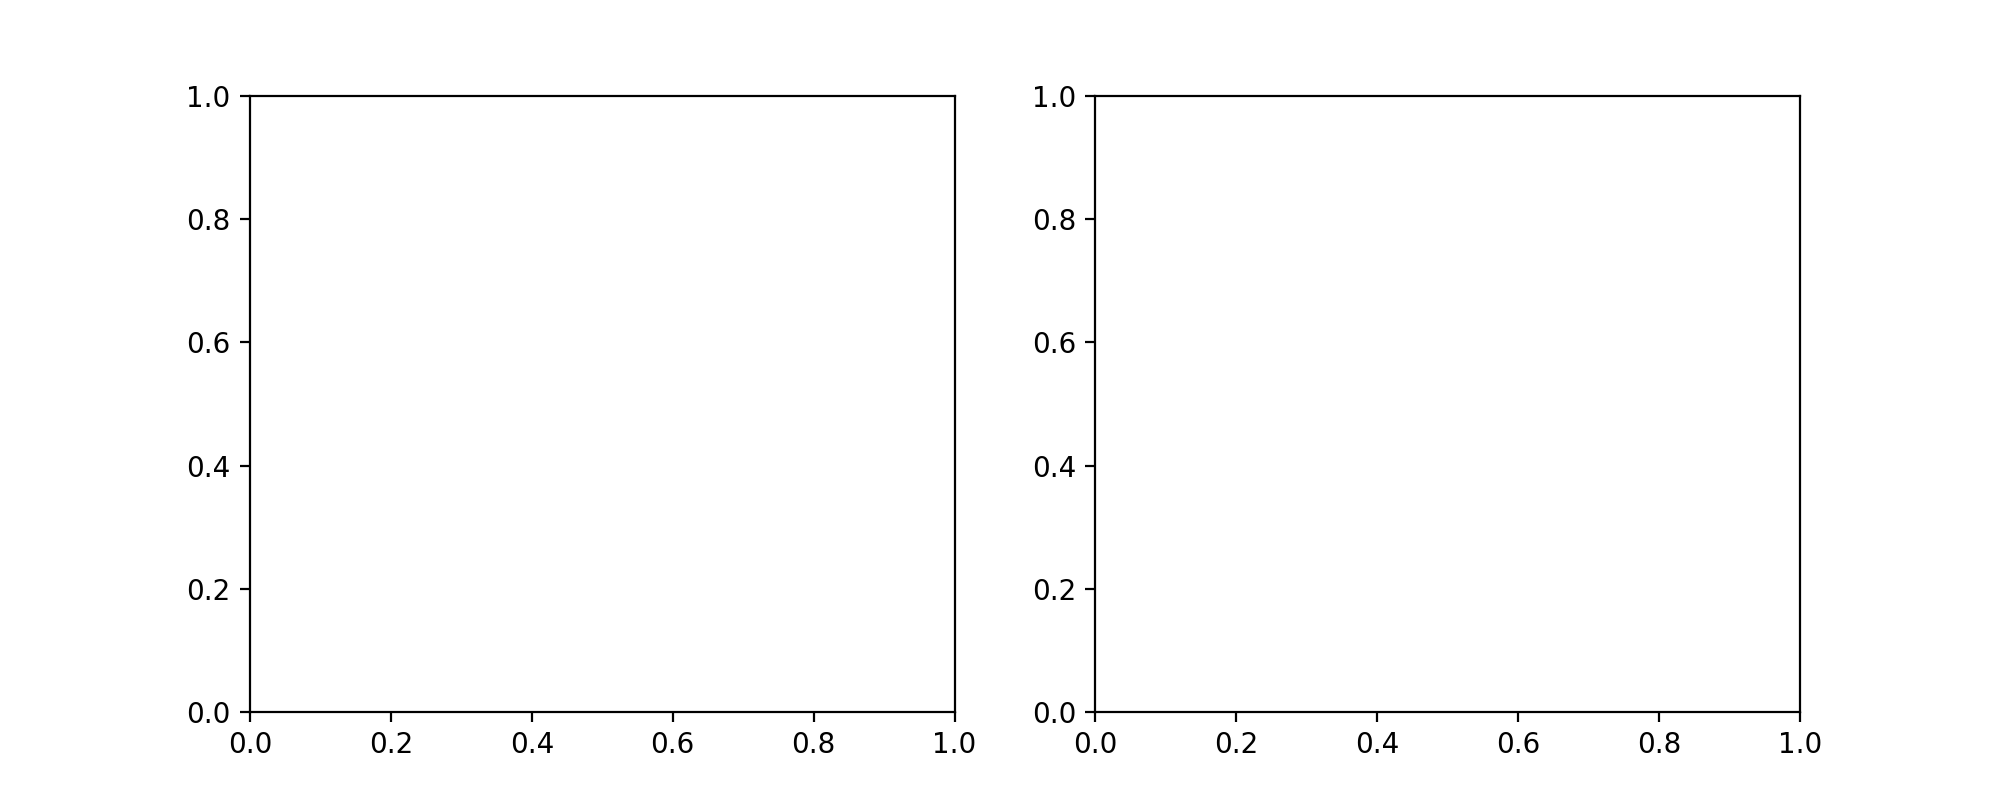

TypeError: area_curve() got an unexpected keyword argument 'ax'

In [69]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
l.area_curve(ax=ax1, log=False)
l.area_curve(ax=ax2, log=True)
# plt.tight_layout()

### Avalanches

<IPython.core.display.Javascript object>


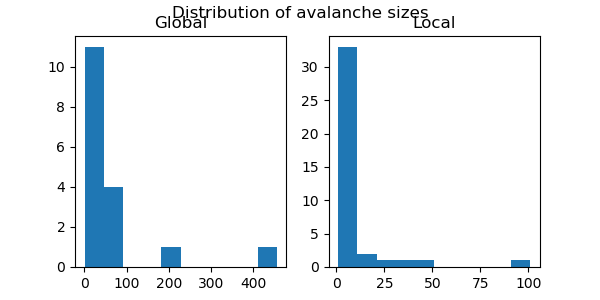

Text(0.5, 0.98, 'Distribution of avalanche sizes')

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
ax1.set_title('Global')
ax1.hist(l.av.trace[1:], bins=10)
ax2.set_title('Local') # sample size = 1
ax2.hist(l.av_local.trace[1:], bins=10)
plt.suptitle("Distribution of avalanche sizes")

### Species spreading over lattice

In [56]:
# create colormap
cmap = matplotlib.cm.get_cmap("jet")
cmap.set_under("white")

# count the most common species
species_count = collections.Counter([x for l in l.data.flatten() for x in l])
spec_id, _ = species_count.most_common(1)[0]

# get the maximum age of the selected species
max_age = 0
for i,j in l.lattice:
    a = l.data[:, i,j]
    present = [spec_id in x for x in a]
    oldest = max(sum(1 if i else 0 for i in g) for k,g in groupby(present))
    max_age = max(max_age, oldest)

# initialise the plot
fig, ax = plt.subplots()
fig.suptitle("Spreading and age of species {}".format(spec_id))
im_data = np.zeros(l.dimensions)
im = ax.imshow(im_data, cmap=cmap, vmin=1, vmax=max_age,
               extent=(0.5, l.dimensions[0]+0.5, 0.5, l.dimensions[1]+0.5))
ax.set_xticks(np.arange(l.dimensions[0])+0.5, minor=True)
ax.set_yticks(np.arange(l.dimensions[1])+0.5, minor=True)
ax.grid(True, which="minor")
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Age (steps)")

# animate function
step_size = 1
def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))
    
    for i,j in np.ndindex(l.dimensions):
        if spec_id in species[i,j]:
            im_data[i,j] += 1
        else:
            im_data[i,j] = 0
    im.set_data(im_data)
    
    return im

# start animation and optionally save as mp4
ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=1000/60, repeat=False, blit=True, save_count=2000)
# ani.save("migration_of_species_{}.mp4".format(spec_id))

AttributeError: 'NoneType' object has no attribute 'flatten'

### Habitat size distribution (varying migration bias)

In [82]:
dimensions = (10,10)
N = 200
steps = 1000 
P = 0.01

migration_biases = [-1, 0, 1]

# run simulations for different migration biases
ls = np.empty(len(migration_biases), dtype=object)
for i, bias in enumerate(migration_biases):
    l = Lattice(dimensions, N=N, network=("watts-strogatz", 3, 0),
                P=P, fitness_correlation=0, migration_bias=bias)
    %time l.run(steps, collect_data=False)
    ls[i] = l

CPU times: user 41.6 s, sys: 39.8 ms, total: 41.6 s
Wall time: 41.6 s
CPU times: user 29.2 s, sys: 115 ms, total: 29.4 s
Wall time: 29.6 s
CPU times: user 44.7 s, sys: 234 ms, total: 45 s
Wall time: 45.8 s


<IPython.core.display.Javascript object>


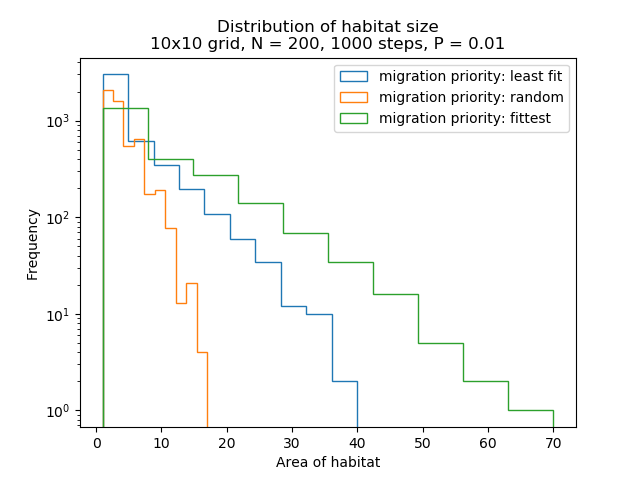

In [83]:
labels = {-1: "least fit", 0: "random", 1:"fittest"}

# plot the habitat size distributions
fig, ax = plt.subplots()
for i, bias in enumerate(migration_biases):
    species_count = collections.Counter([x for p in ls[i].lattice for x in ls[i][p].species_list])
    ax.hist(species_count.values(), bins=None, histtype="step", label="migration priority: {}".format(labels[bias]))

ax.set_yscale("log")
ax.set_title("Distribution of habitat size\n{}x{} grid, N = {}, {} steps, P = {}".format(
    dimensions[0], dimensions[1], N, steps, P))
ax.set_xlabel("Area of habitat")
ax.set_ylabel("Frequency")
ax.legend()

# plt.savefig("habitat_distribution_varying_migration_priority.pdf")

### Habitat size distribution (varying fitness correlation)

In [72]:
dimensions = (10,10)
N = 200
steps = 1000 
P = 0.01

fitness_correlations = np.linspace(0, 0.8, 4)

# run simulations for different migration biases
ls = np.empty(len(fitness_correlations), dtype=object)
for i, corr in enumerate(fitness_correlations):
    l = Lattice(dimensions, N=N, network=("watts-strogatz", 3, 0),
                P=P, fitness_correlation=corr, migration_bias=0)
    %time l.run(steps, collect_data=False)
    ls[i] = l


CPU times: user 28.7 s, sys: 29.6 ms, total: 28.7 s
Wall time: 28.7 s
CPU times: user 29.3 s, sys: 177 ms, total: 29.4 s
Wall time: 29.7 s
CPU times: user 29.1 s, sys: 188 ms, total: 29.3 s
Wall time: 29.5 s
CPU times: user 29.1 s, sys: 205 ms, total: 29.3 s
Wall time: 29.8 s


<IPython.core.display.Javascript object>


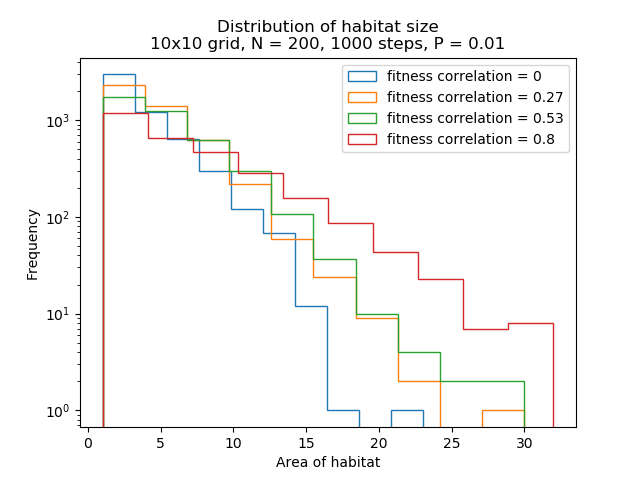

In [81]:
# plot the habitat size distributions
fig, ax = plt.subplots()
for i, corr in enumerate(fitness_correlations):
    species_count = collections.Counter([x for p in ls[i].lattice for x in ls[i][p].species_list])
    ax.hist(species_count.values(), bins=10, histtype="step", label="fitness correlation = {:.2g}".format(corr))


ax.set_title("Distribution of habitat size\n{}x{} grid, N = {}, {} steps, P = {}".format(
    dimensions[0], dimensions[1], N, steps, P))
ax.set_xlabel("Area of habitat")
ax.set_ylabel("Frequency")
# ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

# plt.savefig("habitat_distribution_varying_fitness_correlation.pdf")

### Mean number of species over time

<IPython.core.display.Javascript object>


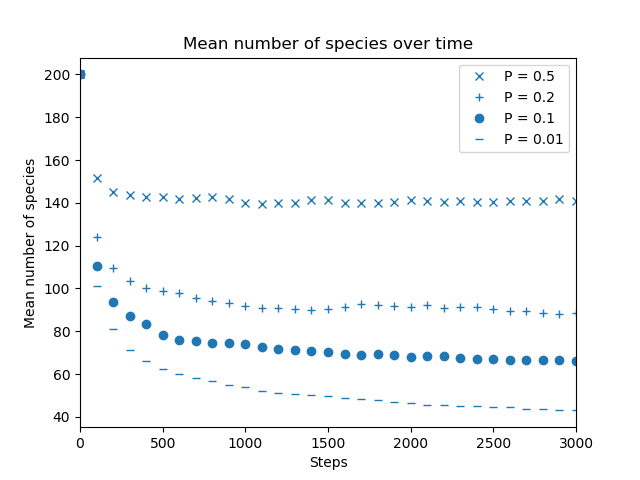

In [84]:
# init simulation
dimensions = (5,5)
Ps = [0.5, 0.2, 0.1, 0.01]
markers = ["x", "+", "o", "_"]
ls = np.empty(len(Ps), dtype=object)
for i, P in enumerate(Ps):
    ls[i] = Lattice(dimensions, 200, ("watts-strogatz", 3, 0),
                    P=P, fitness_correlation=0, migration_bias=0)
step_size = 100
steps = 30

# init plot
fig, ax = plt.subplots()
fig.suptitle("Mean number of species over time")
lines_a = [ax.plot([],[], m, color=plt_color(0), label="P = {}".format(p))[0] for p,m in zip(Ps, markers)]
ax.set_xlim(0, steps*step_size)
ax.set_ylabel("Mean number of species")

ax.set_xlabel("Steps")
ax.legend()

# run simulation and animate
def animate(step):
    if step > 0:
        for i, _ in enumerate(Ps):
            ls[i].run(step_size)

    time = step * step_size
    
    ax.set_title("step: {}".format(time))
    
    for i, _ in enumerate(Ps):
        lines_a[i].set_xdata(np.append(lines_a[i].get_data()[0], [time]))
        lines_a[i].set_ydata(np.append(lines_a[i].get_data()[1], [ls[i].mean_species()]))
    
    ax.relim()
    ax.autoscale_view()
    
    return lines_a

ani = animation.FuncAnimation(fig, animate, np.arange(steps+1), interval=500, repeat=False, blit=True, save_count=1000)

In [85]:
fig.suptitle("")
ax.set_title("Mean number of species over time")
# plt.savefig("mean_number_species_over_time.pdf")

### Average fitness over time

<IPython.core.display.Javascript object>


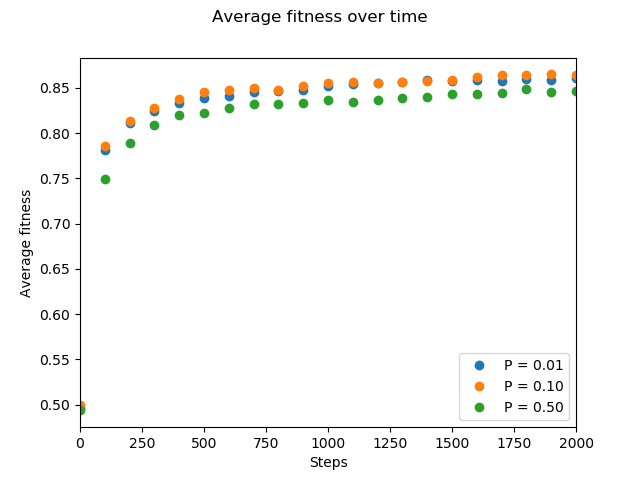

In [30]:
# init simulation
dimensions = (5,5)
Ps = [0.01, 0.1, 0.5]
markers = ["_", "o", "+"]


ls = np.empty(len(Ps), dtype=object)
for i, P in enumerate(Ps):
    ls[i] = Lattice(dimensions, 100, ("watts-strogatz", 3, 0),
                    P=P, fitness_correlation=0.5, migration_bias=1)
step_size = 100
steps = 20
ts = np.arange(steps+1) * step_size

avg_fitness = np.ones((steps+1, len(Ps)))
for i in range(steps+1):
    for j, _ in enumerate(Ps):
        if i > 0:
            ls[j].run(step_size)
        avg_fitness[i, j] = ls[j].avg_fitness()

# plot
fig, ax = plt.subplots()
fig.suptitle("Average fitness over time")
for i, P in enumerate(Ps):
    ax.plot(ts, avg_fitness[:,i], "o", label="P = {:.2f}".format(P))
ax.set_xlim(0, steps*step_size)
ax.set_xlabel("Steps")
ax.set_ylabel("Average fitness")
ax.legend(loc=4)

# plt.savefig("avg_fitness_over_time.pdf")

### Probability distribution of fitness

<IPython.core.display.Javascript object>


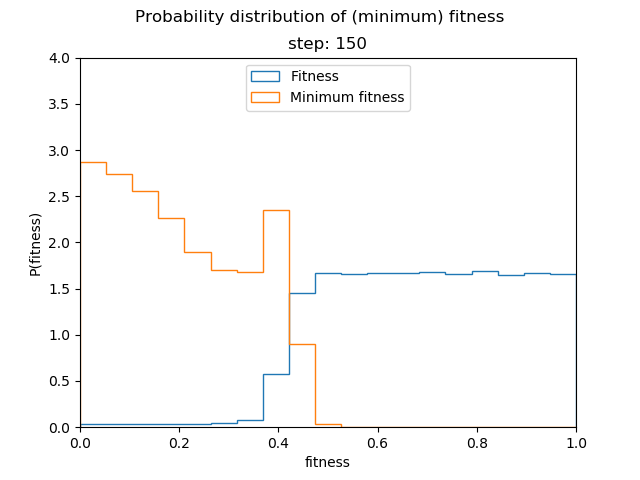

In [5]:
l = Lattice((50,50), N=100, network=("watts-strogatz", 3, 0),
            P=0.1, fitness_correlation=0, migration_bias=0)

steps = 200
step_size = 10
bins = np.linspace(0, 1, 20)

fig, ax = plt.subplots()
fig.suptitle("Probability distribution of (minimum) fitness")
def animate(i):
    if i > 0:
        l.run(step_size)
        
    f_per_point = np.array([l[point].fitness_array() for point in l.lattice])
    fs = f_per_point.flatten()
    min_fs = f_per_point.min(axis=1)   
    t = i * step_size
    
    ax.clear()
    ax.hist(fs, bins, histtype="step", density=True, label="Fitness")
    ax.hist(min_fs, bins, histtype="step", density=True, label="Minimum fitness")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 4)
    ax.set_title("step: {}".format(t))
    ax.set_xlabel("fitness")
    ax.set_ylabel("P(fitness)")
    ax.legend(loc=9)

# animate(1)
ani = animation.FuncAnimation(fig, animate, np.arange(steps+1), interval=1000/10, repeat=False, blit=True, save_count=1000)
# ani.save("fitness distribution.mp4")

### Parameter sweeps